In [0]:
from contextlib import suppress
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import os
import warnings
from zipfile import ZipFile

from skimage.io import imread, imsave

from keras import applications
from keras import optimizers
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, classification_report

In [0]:
source_dir = '/content/drive/My Drive/data/UCMerced_LandUse/Images'

In [0]:
np.random.seed(10)

In [0]:
class_names = os.listdir(source_dir)

In [0]:
flow_base = '/content/drive/My Drive/data/flow'

In [0]:
target_dirs = {target: os.path.join(flow_base, target) for target in ['train', 'validate', 'test']}

if not os.path.isdir(flow_base):

    # Make new directories
    os.mkdir(flow_base)
    
    for target in ['train', 'validate', 'test']:
        target_dir = os.path.join(flow_base, target)
        os.mkdir(target_dir)
        for class_name in class_names:
            class_subdir = os.path.join(target_dir, class_name)
            os.mkdir(class_subdir)
            print(class_subdir)

    
    # Copy images from ./data/UCMerced_LandUse/Images to ./data/flow/<train, validate, test>    
    for root, _, filenames in os.walk(source_dir):
        if filenames:
            class_name = os.path.basename(root)
            print(class_name)
            # Randomly shuffle filenames
            filenames = np.random.permutation(filenames)
            for target, count in [('train', 80), ('validate', 10), ('test', 10)]:
                target_dir = os.path.join(flow_base, target, class_name)
                for filename in filenames[:count]:
                    filepath = os.path.join(root, filename)
                    image = imread(filepath)
                    basename, _ = os.path.splitext(filename)
                    # Convert TIF to PNG to work with Keras ImageDataGenerator.flow_from_directory
                    target_filename = os.path.join(target_dir, basename + '.png')
                    imsave(target_filename, image)
            
                filenames = filenames[count:]
    

In [0]:
means = []
for root, _, filenames in os.walk(target_dirs['train']):
    for filename in filenames:
        filepath = os.path.join(root, filename)
        image = imread(filepath)
        means.append(np.mean(image, axis=(0, 1)))
channel_means = np.mean(means, axis=0)

In [14]:
print(channel_means)

[123.35835817 124.90106496 114.83472256]


In [22]:
print(filenames)

['mediumresidential45.png', 'mediumresidential99.png', 'mediumresidential39.png', 'mediumresidential37.png', 'mediumresidential90.png', 'mediumresidential95.png', 'mediumresidential26.png', 'mediumresidential65.png', 'mediumresidential78.png', 'mediumresidential00.png', 'mediumresidential24.png', 'mediumresidential60.png', 'mediumresidential49.png', 'mediumresidential44.png', 'mediumresidential34.png', 'mediumresidential86.png', 'mediumresidential76.png', 'mediumresidential97.png', 'mediumresidential16.png', 'mediumresidential75.png', 'mediumresidential69.png', 'mediumresidential22.png', 'mediumresidential84.png', 'mediumresidential79.png', 'mediumresidential54.png', 'mediumresidential08.png', 'mediumresidential15.png', 'mediumresidential19.png', 'mediumresidential28.png', 'mediumresidential91.png', 'mediumresidential03.png', 'mediumresidential31.png', 'mediumresidential10.png', 'mediumresidential09.png', 'mediumresidential62.png', 'mediumresidential83.png', 'mediumresidential04.png', 

In [0]:
def get_bottleneck_features(model, dataset, preproc_func, batch_size=64):


  image_data_gen = ImageDataGenerator(rescale=1/255.0, preprocessing_function=preproc_func)
  image_generator = image_data_gen.flow_from_directory(target_dirs[dataset],
                                                             batch_size=batch_size,
                                                             shuffle=False
                                                             )
  image_count = 0
  X_batches, Y_batches = [], []
  for X, Y in image_generator:
    X_batches.append(model.predict_on_batch(X))
    Y_batches.append(Y)
    image_count += X.shape[0]
    # Must interrupt image_generator
    if image_count >= image_generator.n:
      break

  X = np.concatenate(X_batches)
  Y = np.concatenate(Y_batches)

  return X, Y

In [10]:
# Let's try the VGG16 model
pretrained_model = applications.VGG16(include_top=False, weights='imagenet')





58892288/58889256 [==============================] - 2s 0us/step








In [26]:
num_classes = len(class_names)
X, Y = dict(), dict()
preprocess = lambda x: x - channel_means
for dataset in ['train', 'validate', 'test']:
    # Extract bottleneck features from pretrained model, predicting from "dataset" directory
    X[dataset], Y[dataset] = get_bottleneck_features(pretrained_model, dataset, preprocess)

Found 1680 images belonging to 21 classes.
Found 210 images belonging to 21 classes.
Found 210 images belonging to 21 classes.


In [0]:
def build_fully_connected(input_shape, num_classes):

    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [28]:
# Build, compile, and fit the model
model = build_fully_connected(input_shape=X['train'].shape[1:], num_classes=num_classes)
adam = optimizers.Adam(lr=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model_fit_history = model.fit(X['train'], Y['train'], batch_size=64, epochs=50,
                              verbose=2, validation_data=(X['validate'], Y['validate']))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1680 samples, validate on 210 samples
Epoch 1/50
 - 1s - loss: 2.2724 - acc: 0.3452 - val_loss: 1.1514 - val_acc: 0.7476
Epoch 2/50
 - 0s - loss: 1.0989 - acc: 0.6762 - val_loss: 0.7422 - val_acc: 0.8381
Epoch 3/50
 - 0s - loss: 0.7332 - acc: 0.8030 - val_loss: 0.6271 - val_acc: 0.8667
Epoch 4/50
 - 0s - loss: 0.5087 - acc: 0.8762 - val_loss: 0.5134 - val_acc: 0.8810
Epoch 5/50
 - 0s - loss: 0.4028 - acc: 0.9012 - val_loss: 0.4667 - val_acc: 0.8714
Epoch 6/50
 - 0s - loss: 0.3071 - acc: 0.9280 - val_loss: 0.4019 - val_acc: 0.9048
Epoch 7/50
 - 0s - loss: 0.2475 - acc: 0.9518 - val_loss: 0.3755 - val_acc: 0.9048
Epoch 8/50
 - 0s - loss: 0.2052 - acc: 0.9613 - val_loss: 0.3503 - val_acc: 0.9000
Epoch 9/50
 - 0s - loss: 0.1805 - acc: 0.9673 - val_loss: 0.3534 - val_acc:

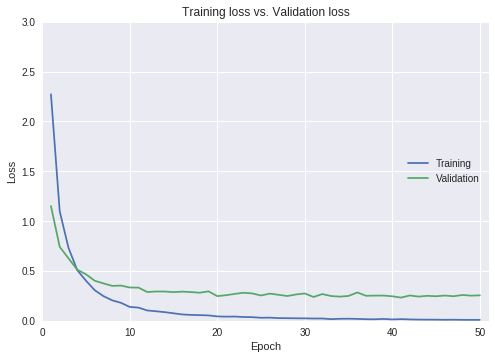

In [29]:
matplotlib.style.use('seaborn')
epochs = len(model_fit_history.history['loss'])
max_loss = max(max(model_fit_history.history['loss']), max(model_fit_history.history['val_loss']))
plt.axis([0, epochs+1, 0, round(max_loss * 2.0) / 2 + 0.5])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['loss'])
plt.plot(x, model_fit_history.history['val_loss'])
plt.title('Training loss vs. Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

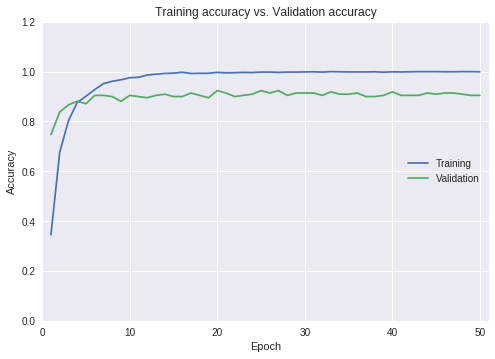

In [30]:
matplotlib.style.use('seaborn')
epochs = len(model_fit_history.history['acc'])
plt.axis([0, epochs+1, 0, 1.2])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['acc'])
plt.plot(x, model_fit_history.history['val_acc'])
plt.title('Training accuracy vs. Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

In [31]:
epochs = np.argmin(model_fit_history.history['val_loss']) + 1
print(f'Stop training at {epochs} epochs')

# Merge training and validation data
X_train = np.concatenate([X['train'], X['validate']])
Y_train = np.concatenate([Y['train'], Y['validate']])

# Randomly shuffle X and Y
shuffle_index = np.random.permutation(len(X_train))
X_train = X_train[shuffle_index]
Y_train = Y_train[shuffle_index]
model = build_fully_connected(input_shape=X_train.shape[1:], num_classes=num_classes)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model_fit_history = model.fit(X_train, Y_train, batch_size=64, epochs=epochs, verbose=0)

Stop training at 41 epochs


In [0]:
# Predict on the test images
y_pred = model.predict_classes(X['test'], verbose=0)

In [33]:
# Flatten Y into a vector
y_test = np.nonzero(Y['test'])[1]
accuracy = accuracy_score(y_test, y_pred)
print(f'Model predication accuracy: {accuracy:.3f}')
print(f'\nClassification report:\n {classification_report(y_test, y_pred)}')

Model predication accuracy: 0.886

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       0.89      0.80      0.84        10
           3       0.91      1.00      0.95        10
           4       0.89      0.80      0.84        10
           5       1.00      1.00      1.00        10
           6       0.33      0.30      0.32        10
           7       0.91      1.00      0.95        10
           8       0.83      1.00      0.91        10
           9       0.90      0.90      0.90        10
          10       1.00      1.00      1.00        10
          11       0.83      1.00      0.91        10
          12       0.58      0.70      0.64        10
          13       0.88      0.70      0.78        10
          14       1.00      0.80      0.89        10
          15       1.00      1.00      1.00        10
          16       0.9

In [34]:
y_pred

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  4,  2,  2,  3,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  6,  4,  4,  4,  4,  4, 19,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6, 12,  6, 12, 13,  6, 12, 11,
       11, 12,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9, 16,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 18, 12, 12, 12, 12,  6,  6, 12, 12, 13,  6,  6,  6, 13, 13,
       13, 13, 13, 13,  8, 14, 14, 14,  8, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19,  9, 19, 19,  7, 19, 19, 12, 20, 20, 20,
       20, 20, 20, 20, 20,  2])

In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  8,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  8,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  2,  4,  1,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0,
         1,  0,  0,